# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Load Training Data

In [2]:
# Read in cars and notcars
car_images = glob.glob('./vehicles/**/*.png', recursive=True)
noncar_images = glob.glob('./non-vehicles/**/*.png', recursive=True)

print(len(car_images))
print(len(noncar_images))

8792
8968


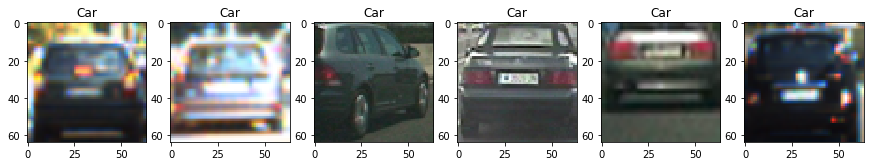

In [3]:
# Visualize some examples of cars
fig, axs = plt.subplots(1,6, figsize=(15,15))

for i in np.arange(6):
    img = mpimg.imread(car_images[np.random.randint(0, len(car_images))])
    axs[i].set_title("Car")
    axs[i].imshow(img)

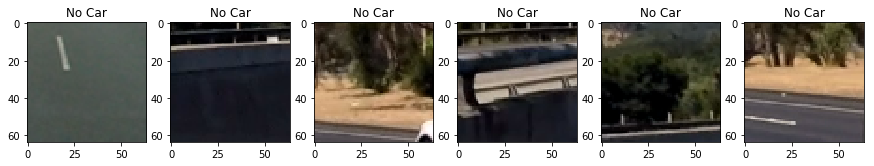

In [4]:
# Visualize some examples of non-cars
fig, axs = plt.subplots(1,6, figsize=(15,15))

for i in np.arange(0,6):
    img = mpimg.imread(noncar_images[np.random.randint(0, len(noncar_images))])
    axs[i].set_title("No Car")
    axs[i].imshow(img)

## Get HOG Features From Image

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Text(0.5,1,'Car HOG Image')

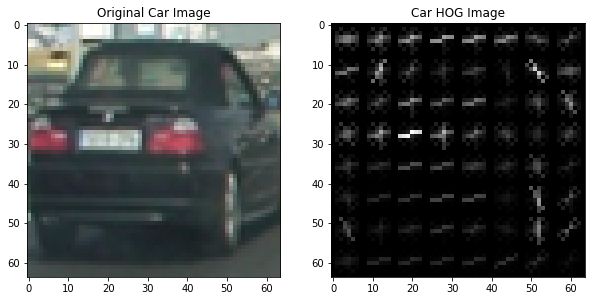

In [6]:
# Visualize HOG on car image
car_image = mpimg.imread(car_images[np.random.randint(0, len(car_images))])

# Use HOG channel 2, orientation 9, pix_per_cell 8 and cell_per_block 8
hog_car_features, hog_car_image = get_hog_features(car_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(car_image)
ax1.set_title("Original Car Image")
ax2.imshow(hog_car_image,cmap='gray')
ax2.set_title("Car HOG Image")

Text(0.5,1,'non-car HOG Image')

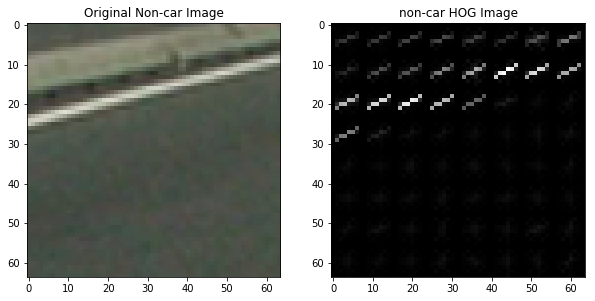

In [7]:
# Visualize HOG on noncar image
noncar_image = mpimg.imread(noncar_images[np.random.randint(0, len(noncar_images))])

# Use HOG channel 2, orientation 9, pix_per_cell 8 and cell_per_block 8
hog_noncar_features, hog_noncar_image = get_hog_features(noncar_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))
ax1.imshow(noncar_image)
ax1.set_title("Original Non-car Image")
ax2.imshow(hog_noncar_image,cmap='gray')
ax2.set_title("non-car HOG Image")

In [8]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=(0, 1))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Extract Features and Create Training and Test Data Sets

In [23]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(car_images, color_space, spatial_size, hist_bins, orient, 
                                pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

notcar_features = extract_features(noncar_images, color_space, spatial_size, hist_bins, orient, 
                                pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

206.27 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


## Train a Linear Classifier

In [24]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

24.74 Seconds to train SVC...
Test Accuracy of SVC =  0.9854
My SVC predicts:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
For these 10 labels:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
0.00176 Seconds to predict 10 labels with SVC


## Find and Draw Rectangle on a Test Image

In the following I will define functions which can find and mark cars on a single image. These will also be used in the video processing pipeline which processes images one at a time

### Extract Features From a Single Window

In [25]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### Calculate Sliding Windows

In [26]:
# Define a function that as input takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y).
# The output is a list of windows, each essentially representing an area of the input image to be searched
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    
    return window_list

### Sliding Windows Search in an Image 

In [27]:
# This function is passed an image, the list of windows to be searched (output of slide_windows())
# The function also takes the trained classifier, scaler and all parameters to extract features
# Then the function extracts features in each of the input list of windows using the single_img_features()
# function defined above. The features are fed to the classifier to check whether the window contains 
# a car image or not. Finally the function returns all windows in which the classifier found a car match.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

### Draw Boxes on an Image

In [28]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Define a Set of Sliding Windows

Number of windows in first set: 38
Number of windows in second set: 57
Number of windows in third set: 160


Text(0.5,1,'Third search set')

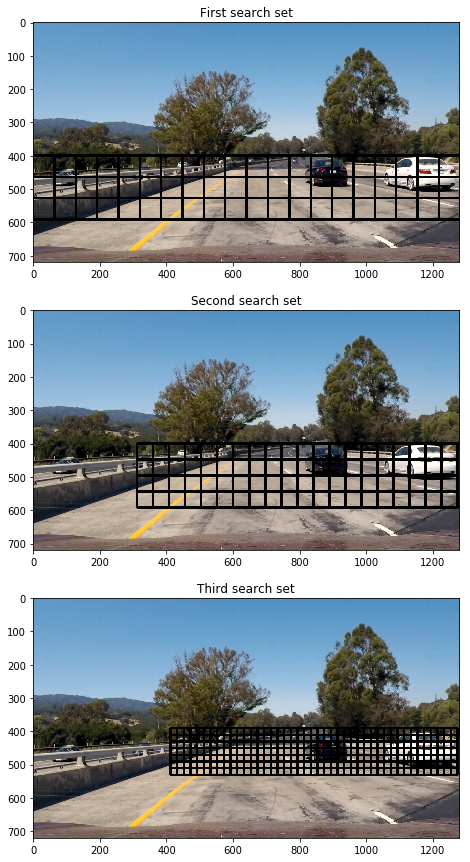

In [29]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)

# Define 3 sets of sliding windows limits
#x_limits = [[None, None], [320, None], [412, 1280]]
x_limits = [[None, None], [312, None], [412, None]]
y_limits = [[400, 640], [400, 600], [390, 540]]
window_size = [(128, 128), (96, 96), (80, 80)]
overlap = [(0.5, 0.5), (0.5, 0.5), (0.75, 0.75)]

sliding_windows_set = []

# Calculate first set
sliding_windows1 = slide_window(image, x_start_stop=x_limits[0], y_start_stop=y_limits[0], 
                    xy_window=window_size[0], xy_overlap=overlap[0])

windows1_img = draw_boxes(draw_image, sliding_windows1, color=(0, 0, 0), thick=6)  

sliding_windows_set.append(sliding_windows1)
print("Number of windows in first set: " + str(len(sliding_windows_set[0])))

# Second set
sliding_windows2 = slide_window(image, x_start_stop=x_limits[1], y_start_stop=y_limits[1], 
                    xy_window=window_size[1], xy_overlap=overlap[1])

windows2_img = draw_boxes(draw_image, sliding_windows2, color=(0, 0, 0), thick=6)                    

sliding_windows_set.append(sliding_windows2)
print("Number of windows in second set: " + str(len(sliding_windows_set[1])))

# Third set
sliding_windows3 = slide_window(image, x_start_stop=x_limits[2], y_start_stop=y_limits[2], 
                    xy_window=window_size[2], xy_overlap=overlap[2])

windows3_img = draw_boxes(draw_image, sliding_windows3, color=(0, 0, 0), thick=6) 

sliding_windows_set.append(sliding_windows3)
print("Number of windows in third set: " + str(len(sliding_windows_set[2])))

# Display the search windows
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15,15))
ax1.imshow(windows1_img)
ax1.set_title("First search set")
ax2.imshow(windows2_img)
ax2.set_title("Second search set")
ax3.imshow(windows3_img)
ax3.set_title("Third search set")

### Define a Function to Search for Cars Using the Pre-defined Set of Sliding Windows

In [30]:
def find_cars(image):
    sum_hot_windows = []
    
    for i in range(len(sliding_windows_set)):
        hot_windows = search_windows(image, sliding_windows_set[i], svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        
        sum_hot_windows.extend(hot_windows)
        
    return sum_hot_windows

### Test Using the Test Images

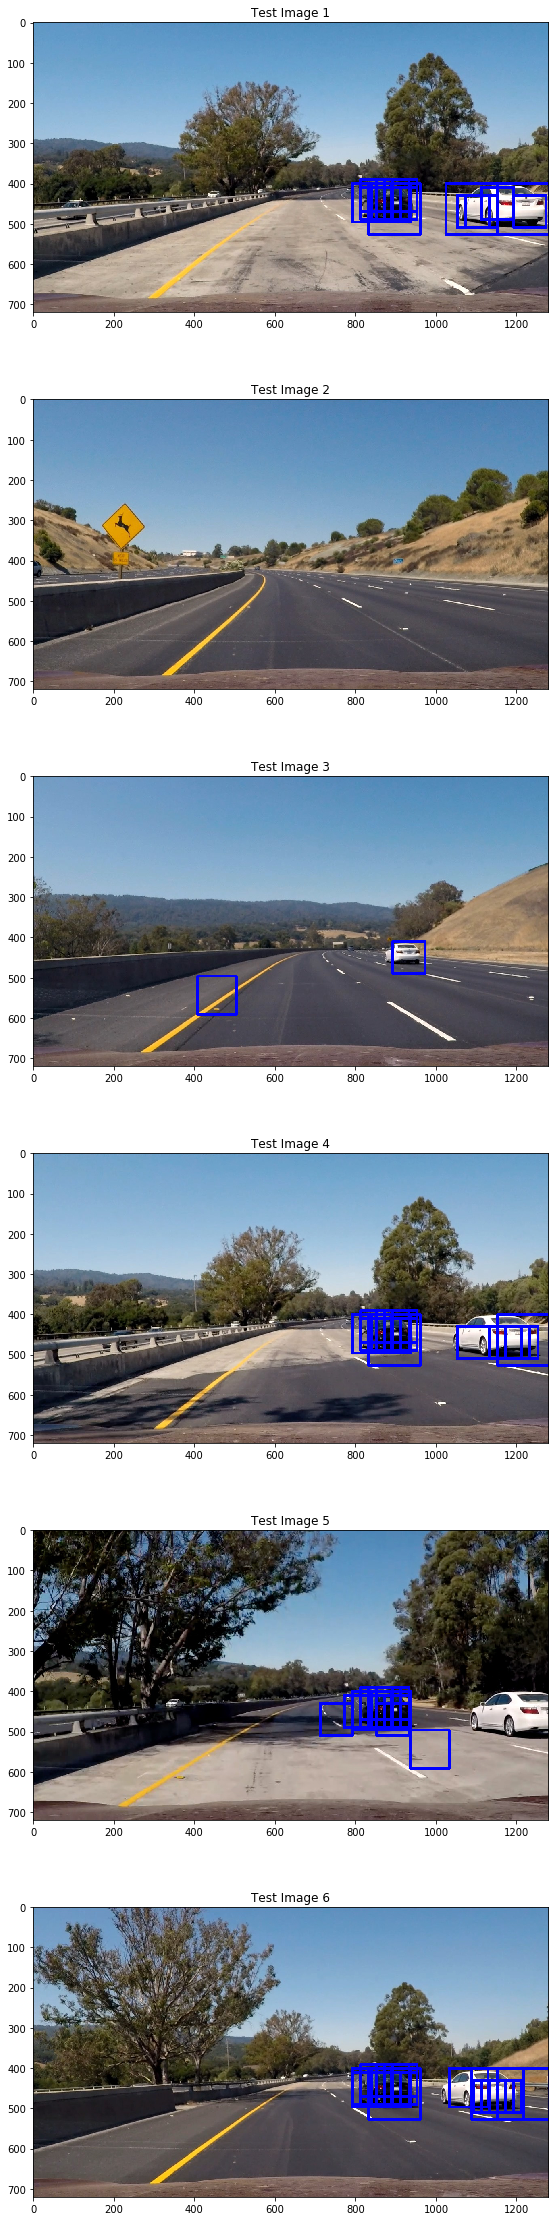

In [31]:
test_images = glob.glob('./test_images/*.jpg')
num_test_images = len(test_images)

f, a = plt.subplots(num_test_images, 1, figsize=(40,40))

for i in range(num_test_images):
    image = mpimg.imread(test_images[i])
    draw_image = np.copy(image)

    image = image.astype(np.float32)/255

    hot_windows = find_cars(image)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    a[i].imshow(window_img)
    a[i].set_title("Test Image " + str(i+1))

f.subplots_adjust(hspace=0.3)

## HOG Subsampling

The disadvantage of the code above is that it is very inefficient. From the course material I will make use of the function to perform HOG sub-sampling.

In [32]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# The function expects correctly scaled images
def advanced_find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                       spatial_size, hist_bins):
    
    rectangles = []
    
    img_tosearch = img[ystart:ystop,:,:]
 
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)      

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

Now define a function which calls the advanced_find_cars() a number of times with different parameters, to increase the likelihood of finding cars.

In [33]:
def get_relevant_rectangles(test_image):
    collected_windows = []

    ####### 1.
    ystart = 416
    ystop = 480
    scale = 1.0

    w = advanced_find_cars(test_image, color_space, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    collected_windows.append(w)

    ####### 2.
    ystart = 432
    ystop = 528
    scale = 1.5

    w = advanced_find_cars(test_image, color_space, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    collected_windows.append(w)

    ####### 3.
    ystart = 400
    ystop = 528
    scale = 2.0

    w = advanced_find_cars(test_image, color_space, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    collected_windows.append(w)

    ####### 4.
    ystart = 400
    ystop = 596
    scale = 3.5

    w = advanced_find_cars(test_image, color_space, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    collected_windows.append(w)

    ####### 5.
    ystart = 464
    ystop = 640
    scale = 3.5

    w = advanced_find_cars(test_image, color_space, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    collected_windows.append(w)

    # Flatten the collected windows list
    collected_windows = [item for sublist in collected_windows for item in sublist]

    return(collected_windows)

### Test HOG Subsampling on a Single Image

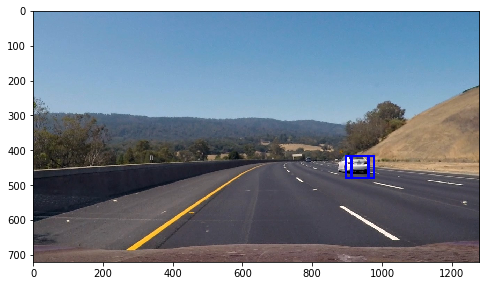

In [34]:
test_image = mpimg.imread('./test_images/test3.jpg')
draw_image = np.copy(test_image)
test_image = test_image.astype(np.float32)/255

rects = get_relevant_rectangles(test_image)

window_img = draw_boxes(draw_image, rects, color=(0, 0, 255), thick=6)                    

plt.figure(figsize=(8,8))
plt.imshow(window_img)

### Test HOG Subsampling of All Test Images

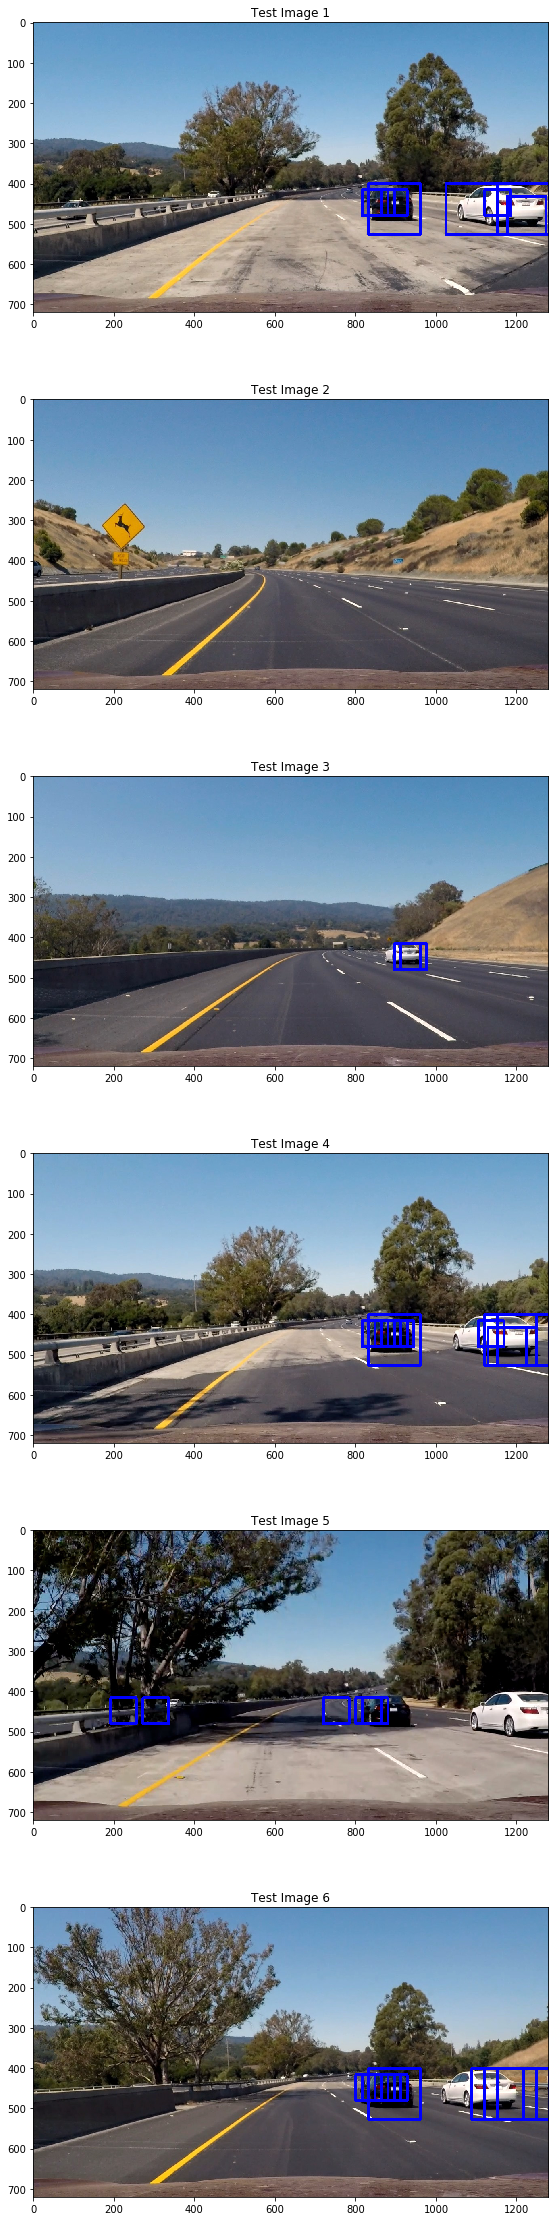

In [35]:
test_images = glob.glob('./test_images/*.jpg')
num_test_images = len(test_images)

f, a = plt.subplots(num_test_images, 1, figsize=(40,40))

for i in range(num_test_images):
    image = mpimg.imread(test_images[i])
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    hot_rects = get_relevant_rectangles(image)
    
    window_img = draw_boxes(draw_image, hot_rects, color=(0, 0, 255), thick=6)                    

    a[i].imshow(window_img)
    a[i].set_title("Test Image " + str(i+1))

f.subplots_adjust(hspace=0.3)

### Heatmap

Produce a heat map based on rectangle locations.

In [36]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Test the function.

Text(0.5,1,'Heat Image')

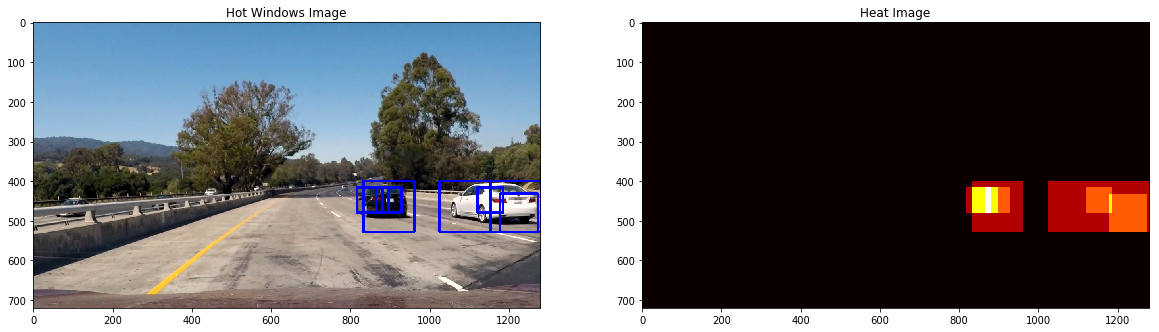

In [37]:
test1_image = mpimg.imread('./test_images/test1.jpg')

draw_image = np.copy(test1_image)
heat_image = np.zeros_like(test1_image[:,:,0]).astype(np.float)

test1_image = test1_image.astype(np.float32)/255

hot_windows = get_relevant_rectangles(test1_image)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# Add heat to each box in box list
heat_image = add_heat(heat_image, hot_windows)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(window_img)
ax1.set_title("Hot Windows Image")
ax2.imshow(heat_image,cmap='hot')
ax2.set_title("Heat Image")

### Apply a Threshold to the Heatmap

In [38]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

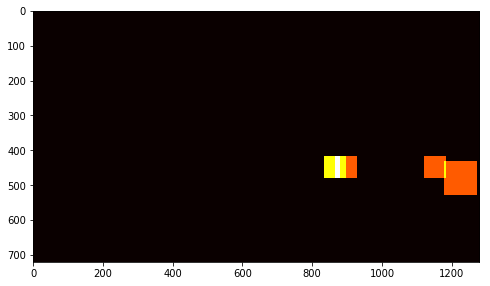

In [39]:
heat_image = apply_threshold(heat_image, 1)

plt.figure(figsize=(8,8))
plt.imshow(heat_image, cmap='hot')

### Apply SciPy Labels to Heatmap

2 cars found


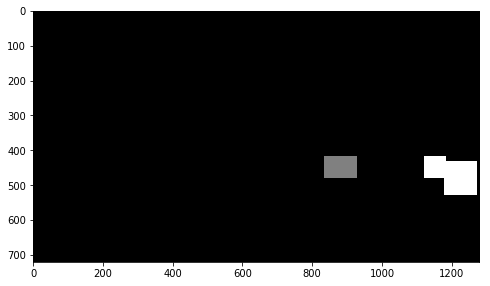

In [40]:
labels = label(heat_image)

plt.figure(figsize=(8,8))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes on Original Image Based on Labels

In [127]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if(bbox[1][0] - bbox[0][0] > 50):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

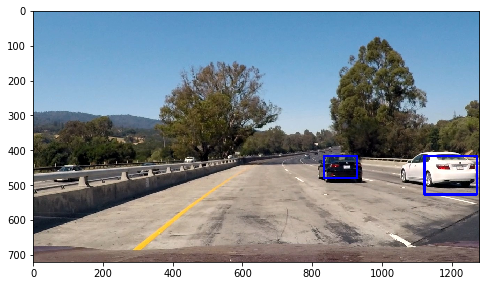

In [128]:
result_img = draw_labeled_bboxes(draw_image, labels)

plt.figure(figsize=(8,8))
plt.imshow(result_img)

## The Video Processing Pipeline

First I will define a small class to store the rectangles of detected cars from previous video frames.

In [132]:
class Detected_Cars():
    def __init__(self):
        self.prev_windows = []
        
    def add_windows(self, new_windows):
        temp_list = []
        num_new_windows = len(new_windows)

        for i in range(num_new_windows):
            upper_left_corner = new_windows[i][0]
            lower_right_corner = new_windows[i][1]

            x1 = upper_left_corner[0]
            y1 = upper_left_corner[1]
            x2 = lower_right_corner[0]
            y2 = lower_right_corner[1]
            
            # The lower left corner of the window must be located in the part of the
            # picture which is the road. The equation x = -2.25*y + 1800 estimates the
            # left road limit.
            if(x2 > -2.25*y2 + 1800 and x2 - x1 > 50):
                temp_list.append([upper_left_corner, lower_right_corner])

            self.prev_windows.append(temp_list)
                    
        if(len(self.prev_windows) > 15):
            # Use slicing to remove first (oldest) element
            self.prev_windows = self.prev_windows[1:]

### The Pipeline

Here we take advantage of all the previously defined functions, most notably we will use the pre-trained Linear classifier, and the pre defined set of sliding windows

In [137]:
def process_image(image):
    # Make copies for processing
    draw_image = np.copy(image)
    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Scale as classifier is trained with .png images
    image = image.astype(np.float32)/255

    # Get the windows with cars for this images
    hot_windows = get_relevant_rectangles(image)
    
    # Store them
    if(len(hot_windows) > 0):
        detected_cars.add_windows(hot_windows)
        
    # Use the stored set of windows for generating the heat map
    for windows_set in detected_cars.prev_windows:
        heat_image = add_heat(heat_image, windows_set)
        
    # Threshold it to remove false positives
    heat_image = apply_threshold(heat_image, 2 + len(detected_cars.prev_windows)//2)
    
    # Get the unique cars
    labels = label(heat_image)
    
    # Draw the bounding boxes
    result_img = draw_labeled_bboxes(draw_image, labels)
    
    return result_img

### Process the Project Video

In [138]:
detected_cars = Detected_Cars()

video_output = 'project_video_output.mp4'
#video_input = VideoFileClip("project_video.mp4").subclip(19,25)
#video_input = VideoFileClip("project_video.mp4").subclip(27,31)
#video_input = VideoFileClip("test_video.mp4")
video_input = VideoFileClip("project_video.mp4")
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 12%|█▏        | 152/1261 [01:58<14:31,  1.27it/s]


 24%|██▍       | 303/1261 [03:58<12:40,  1.26it/s]


 36%|███▌      | 454/1261 [05:58<10:43,  1.25it/s]


 48%|████▊     | 605/1261 [07:58<08:39,  1.26it/s]


 60%|█████▉    | 756/1261 [09:58<06:44,  1.25it/s]


 72%|███████▏  | 907/1261 [12:00<04:46,  1.23it/s]


 84%|████████▍ | 1057/1261 [14:02<02:42,  1.25it/s]


 96%|█████████▌| 1205/1261 [16:01<00:44,  1.25it/s]


100%|█████████▉| 1260/1261 [16:45<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 16min 20s, sys: 35.2 s, total: 16min 55s
Wall time: 16min 46s
